Assignment: Flowers Recognition <br>
Dataset Description:<br>

This dataset contains 4242 images of flowers.<br>
The data collection is based on the data flicr, google images, yandex images.<br>
You can use this datastet to recognize plants from the photo.<br>

Attribute Information:<br>
The pictures are divided into five classes: 0daisy, 1tulip, 2rose, 3sunflower, 4dandelion.<br>
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. <br>
<b>Also explore how to resize images in tensorflow and then resize all the images to a same size. </b> <br>
This is a Multiclass Classification Problem.<br>



WORKFLOW : <br>
Load Data <br>
Split into 60 and 40 ratio.<br>
Encode labels.<br>
Create Model<br>
Compilation Step (Note : Its a Multiclass Classification problem , select loss , metrics according to it)<br>
Train the Model.<br>
If the model gets overfit tune your model by changing the units , No. of layers , epochs , add dropout layer or add Regularizer according to the need .<br>
Prediction should be > 85%<br>
Evaluation Step<br>
Prediction<br>




Data : <br>
https://drive.google.com/file/d/1-OX6wn5gA-bJpjPNfSyaYQLz-A-AB_uj/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
#from fastai.basics import *
#import random
import sys
import time
import cv2
import numpy as np
import tensorflow as tf
import os
import zipfile
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

2.4.1


In [ ]:
sys.version

'3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]'

extract files from zip file

In [ ]:
zip_ref = zipfile.ZipFile('drive/My Drive/Colab Notebooks/Q2Assignments/flowers.zip', 'r')
zip_ref.extractall('unzipped_folder') # unzip directory
zip_ref.close()

In [ ]:
base_path = 'unzipped_folder/flowers/'
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

load images

In [ ]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [ ]:
print('length for each category:', [len(f) for f in fnames])

length for each category: [769, 1055, 784, 734, 984]


Loading images

In [ ]:
# train, test = train_test_split(fnames[0], train_size=0.8)
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [ ]:
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [769, 1052, 784, 734, 984]


Minimum shape of all images

In [ ]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

125,134 is the min shape for daisy
98,134 is the min shape for dandelion
80,150 is the min shape for rose
134,152 is the min shape for sunflower
134,134 is the min shape for tulip


convert cv2 BGR format to RGB

In [ ]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

sample images for all flowers

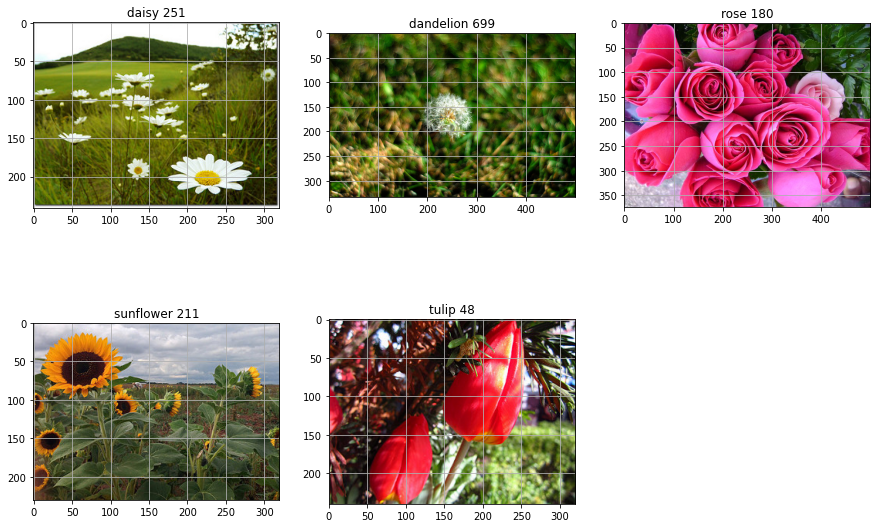

In [ ]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

Resize all the images to 320x240

(218, 320, 3)
(256, 256, 3)


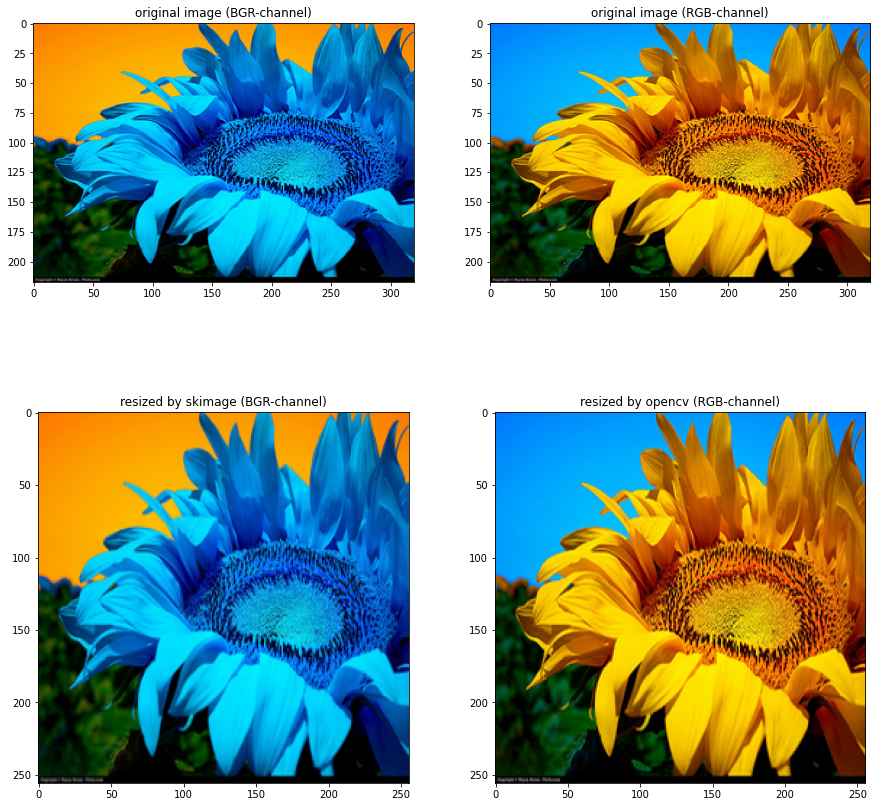

In [ ]:
img_width, img_height = 256, 256 ##

img = images[3][659]
print(img.shape)
resized_img = resize(img, (img_width, img_height, 3))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(resized_img.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized by skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized by opencv (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()

In [ ]:
# Apply resize to all images
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

Split dataset to 80% of training and 20% of validation

In [ ]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

Creat labels

In [ ]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[615, 841, 627, 587, 787]
sum of train images: 3457
[154, 211, 157, 147, 197]
sum of val_images: 866


Convert image data to numpy array
Convert and pre-processing
convert class labels to binary class labels

In [ ]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [ ]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

Before converting
train data: (3457, 256, 256, 3)
train labels: (3457,)

After converting
train data: (3457, 256, 256, 3)
train labels: (3457, 5)


Shuffle the dataset (set a seed and randomize both the data and the labels)

In [ ]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [ ]:
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (3400, 256, 256, 3)
shape of train labels: (3400, 5)
shape of val data: (860, 256, 256, 3)
shape of val labels: (860, 5)


Build the model

In [ ]:
def create_model_from_scratch():

    """
     train from scratch
    """
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=train_data.shape[1:], activation='relu', name='conv_1'))
    model.add(Conv2D(32, (3,3), activation='relu', name='conv_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_1'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'))
    model.add(Conv2D(64, (3,3), activation='relu', name='conv_4'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_2'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'))
    model.add(Conv2D(128, (3,3), activation='relu', name='conv_6'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_3'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dense(128, activation='relu', name='dense_2'))
    model.add(Dense(len(categories), name='output'))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [ ]:
model_scratch = create_model_from_scratch()
model_scratch.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 254, 254, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 127, 127, 64)      18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 125, 125, 64)      36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 62, 62, 64)        0

Prepare input data

In [ ]:
# Parameters
batch_size = 32
epochs = 2

Create generator

In [ ]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, width_shift_range=0.4, 
                                   height_shift_range=0.4, shear_range=0.2, 
                                   zoom_range=0.3, horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(train_data, train_labels, batch_size=batch_size)

val_generator = val_datagen.flow(val_data, val_labels, batch_size=batch_size)

Train the model

Fit the model with generator

In [ ]:
start = time.time()

model_scratch_info = model_scratch.fit(train_generator, epochs=2, batch_size = 32, validation_data=val_generator)

end = time.time()
duration = end - start
print ('\n model_scratch took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

In [ ]:
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

In [ ]:
# plt.figure(figsize=(15,15))
# # indexs = [10, 20, 30, 40, 50, 60, ]
# for i in range(9):
#   idx = np.random.randint(860)
#   plt.subplot(3,3,i+1)
#   plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
#   category_idx = return_name(val_labels[idx])
#   plt.title(categories[category_idx])
#   plt.grid('off')
# plt.show()

Predict and evaluate the model

In [ ]:
# Plots for training and testing process: loss and accuracy

def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()

model_scratch


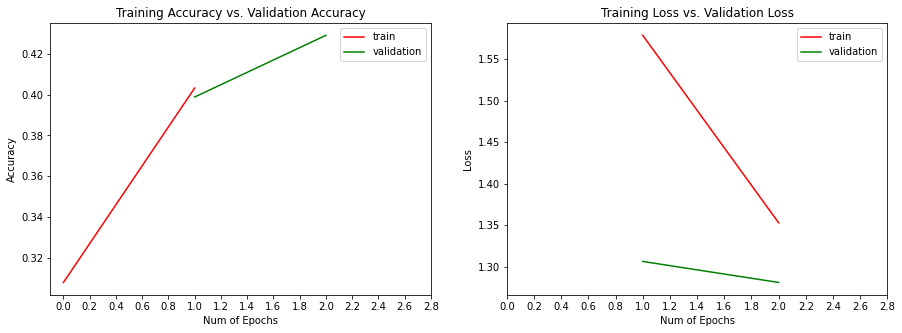

In [ ]:
plot_model_history('model_scratch', model_scratch_info.history, epochs)

Predict one image

In [ ]:
def predict_one_image(img, model):
  img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
  img = np.reshape(img, (1, img_width, img_height, 3))
  img = img/255.
  pred = model.predict(img)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

In [ ]:
def predict_val(val_data, model):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)